In [1]:
pip install tensorflow-datasets

Note: you may need to restart the kernel to use updated packages.


In [2]:
# import library
import numpy as np
import tensorflow_datasets as tfds
import tensorflow as tf

# menonaktifkan tampilan progress bar saat mengunduh atau memproses dataset dengan TensorFlow Dataset
tfds.disable_progress_bar()

In [3]:
import matplotlib.pyplot as plt

# deklarasi fungsi dengan parameter history(riwayat pelatihan model) dan mteric(metrik yg ingin digambar)
def plot_graphs(history, metric):
  # membuat garis yang mewakili nilai metrik yang diberikan (seperti akurasi) selama setiap epoch pelatihan.
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  # menambahkan label sumbu x (absis) pada grafik dan memberikannya label "Epochs", yang mengindikasikan bahwa nilai-nilai di sumbu x akan mewakili epoch pelatihan.
  plt.xlabel("Epochs")
  # menambahkan label sumbu y (ordinat) pada grafik dan memberikannya label yang sesuai dengan metrik yang diberikan, yang diambil dari argumen metric.
  plt.ylabel(metric)
  # perintah yang menambahkan legenda ke grafik untuk menjelaskan garis apa yang mewakili. Ini akan menampilkan label berdasarkan metrik dan "val_" metrik untuk membedakan antara metrik pelatihan dan validasi dalam grafik.
  plt.legend([metric, 'val_'+metric])

In [4]:
# mengambil informasi tentang dataset, seperti jumlah sampel, fitur, dan lainnya. 
dataset, info = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

# mengakses properti element_spec dari train_dataset. Properti ini memberikan informasi tentang struktur elemen individu dalam dataset, seperti jenis data dan bentuknya.
train_dataset.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [5]:
# mengambil satu contoh (1) dari dataset dan mencetak teks ulasan serta label sentimen yang sesuai.
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0


In [6]:
# menentukan ukuran buffer yang digunakan saat pengacakan elemen dalam dataset pelatihan. Ini berguna untuk mengacak urutan data dalam setiap epoch.
BUFFER_SIZE = 10000
# menentukan ukuran batch yang digunakan saat mengambil beberapa sampel untuk pemrosesan bersamaan dalam pelatihan atau pengujian model.
BATCH_SIZE = 64

# mengacak lalu mengelompokkan elemen-elemen dataset ke dalam batch dengan ukuran yang telah ditentukan.
# mengoptimalkan pemrosesan data dengan otomatis menentukan ukuran prefetch buffer.
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# loop yang mengambil satu batch dari train_dataset untuk tujuan demonstrasi.
for example, label in train_dataset.take(1):
  # mencetak teks ulasan dari tiga sampel pertama dalam batch.
  print('texts: ', example.numpy()[:3])
  print()
  #  mencetak label sentimen dari tiga sampel pertama dalam batch.
  print('labels: ', label.numpy()[:3])


texts:  [b'I grew up on the \'Superman II\' theatrical version ("S2T") and as a kid, I loved it more than Part I since not only did it contain more Superman and three Superman-type villains, it started off with a bang \xc2\x96 the best Clark Kent to Superman transformations and rescue scenes. Kids no longer had to impatiently wait for Superman to appear on screen, as in part I. Now as an adult, I can see how the mighty had fallen with S2T (See: my review.) I\'ve always heard of the back-story on how they prematurely and unjustifiably fired the original\'s director, Richard Donner from part II. (It must have been a rarity back then to film two separate movies simultaneously, now it\'s common: \'Back to the Future\' and \'Matrix\' 2 & 3 for example.) Unfortunately, after finally seeing the Richard Donner Cut (or, "S2RD") I still can\'t fully recommend it. Gone, was the great Superman change scene, the entire Paris rescue, as was the wonderful recap of part I in S2T\'s opening. In fact, t

In [7]:
# menentukan ukuran kosakata (vocabulary size) yang akan digunakan untuk mengkodekan kata-kata dalam teks. Ini berarti hanya 1000 kata paling umum akan dimasukkan ke dalam kosakata.
VOCAB_SIZE = 1000
# menentukan jumlah maksimum kata yang akan disimpan dalam kosakata.
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
# memeriksa teks dalam dataset pelatihan untuk membangun kosakata dan menentukan pengkodean kata.
encoder.adapt(train_dataset.map(lambda text, label: text))

In [8]:
# endapatkan kosakata yang telah dibangun oleh objek encoder, dan kemudian mencetak 20 kata pertama dalam kosakata tersebut.
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

In [9]:
# menggunakan encoder untuk mengonversi tiga sampel teks ulasan pertama dari example menjadi representasi vektor numerik, dan kemudian mengonversinya menjadi array NumPy.
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[ 10,   1,  58, ...,   0,   0,   0],
       [  1,   6,   2, ...,   0,   0,   0],
       [  3, 833,   1, ...,   0,   0,   0]], dtype=int64)

In [10]:
# mencetak tiga contoh "round-trip" dari teks ulasan
# membandingkan teks asli dengan teks yang dihasilkan kembali dari representasi vektor numerik. 
# mencetak teks asli, kemudian teks yang dihasilkan kembali dari representasi vektor numerik, dan memberikan baris kosong sebagai pemisah.
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b'I grew up on the \'Superman II\' theatrical version ("S2T") and as a kid, I loved it more than Part I since not only did it contain more Superman and three Superman-type villains, it started off with a bang \xc2\x96 the best Clark Kent to Superman transformations and rescue scenes. Kids no longer had to impatiently wait for Superman to appear on screen, as in part I. Now as an adult, I can see how the mighty had fallen with S2T (See: my review.) I\'ve always heard of the back-story on how they prematurely and unjustifiably fired the original\'s director, Richard Donner from part II. (It must have been a rarity back then to film two separate movies simultaneously, now it\'s common: \'Back to the Future\' and \'Matrix\' 2 & 3 for example.) Unfortunately, after finally seeing the Richard Donner Cut (or, "S2RD") I still can\'t fully recommend it. Gone, was the great Superman change scene, the entire Paris rescue, as was the wonderful recap of part I in S2T\'s opening. In fact,

In [11]:
# mengonversi teks ulasan menjadi representasi vektor numerik.
# mengubah vektor numerik yang dihasilkan oleh encoder menjadi representasi embedding dengan dimensi yang lebih rendah. 
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    # lapisan RNN yang menggunakan arah ganda (bidirectional) dan mengandung sel LSTM (Long Short-Term Memory) dengan 64 unit.
    # Lapisan LSTM digunakan untuk memahami konteks teks dalam kedua arah (ke depan dan ke belakang).
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    # lapisan fully connected (dense) dengan 64 unit dan fungsi aktivasi ReLU (Rectified Linear Unit).
    tf.keras.layers.Dense(64, activation='relu'),
    # lapisan fully connected terakhir dengan satu unit yang digunakan untuk melakukan klasifikasi biner, dengan keluaran akhir yang dapat digunakan untuk mengukur sentimen positif atau negatif.
    tf.keras.layers.Dense(1)
])

In [12]:
# mencetak daftar True dan False yang menunjukkan apakah setiap lapisan dalam model mendukung masking atau tidak.
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


In [13]:
# predict on a sample text without padding.

# mengkodekan dan melakukan padding pada teks sebelum memasukkannya ke dalam model untuk prediksi sentimen.
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

1/1 [==============================] - 16s 16s/step
[-0.01909289]


In [14]:
# predict on a sample text with padding

# melakukan prediksi sentimen pada dua teks: satu adalah teks sample_text yang tidak memerlukan padding, dan yang lainnya adalah teks yang memiliki padding dalam bentuk panjang teks yang sangat panjang.
padding = "the " * 2000
predictions = model.predict(np.array([sample_text, padding]))
print(predictions[0])

1/1 [==============================] - 1s 1s/step
[-0.01909289]


In [15]:
# fungsi kerugian (loss function) yang digunakan dalam pelatihan model.
# pengoptimal yang digunakan selama pelatihan model. Anda menggunakan pengoptimal Adam dengan tingkat pembelajaran (learning rate) sebesar 1e-4 (0.0001). 
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              # mengevaluasi kinerja model selama pelatihan
              metrics=['accuracy'])

In [16]:
# menggunakan model yang telah dikompilasi untuk melatih model dengan dataset pelatihan (train_dataset) selama 10 epoch, sambil juga melakukan validasi dengan dataset pengujian (test_dataset). 
history = model.fit(train_dataset, epochs=10, validation_data=test_dataset, validation_steps=30)

Epoch 1/10
391/391 [==============================] - 3357s 8s/step - loss: 0.6218 - accuracy: 0.5848 - val_loss: 0.4487 - val_accuracy: 0.7688
Epoch 2/10
391/391 [==============================] - 3483s 9s/step - loss: 0.3838 - accuracy: 0.8245 - val_loss: 0.3489 - val_accuracy: 0.8479
Epoch 3/10
391/391 [==============================] - 3662s 9s/step - loss: 0.3338 - accuracy: 0.8522 - val_loss: 0.3418 - val_accuracy: 0.8568
Epoch 4/10
391/391 [==============================] - 3457s 9s/step - loss: 0.3191 - accuracy: 0.8614 - val_loss: 0.3460 - val_accuracy: 0.8615
Epoch 5/10
391/391 [==============================] - 3456s 9s/step - loss: 0.3132 - accuracy: 0.8631 - val_loss: 0.3256 - val_accuracy: 0.8531
Epoch 6/10
391/391 [==============================] - 3951s 10s/step - loss: 0.3105 - accuracy: 0.8657 - val_loss: 0.3314 - val_accuracy: 0.8448
Epoch 7/10
391/391 [==============================] - 3656s 9s/step - loss: 0.3041 - accuracy: 0.8695 - val_loss: 0.3261 - val_accuracy

In [17]:
# pemanggilan metode evaluate pada model dengan dataset pengujian (test_dataset). 
# Metode ini akan menghitung loss dan akurasi model pada dataset pengujian.
test_loss, test_acc = model.evaluate(test_dataset)

# mencetak nilai loss pengujian ke layar.
print('Test Loss:', test_loss)
# mencetak nilai akurasi pengujian ke layar.
print('Test Accuracy:', test_acc)

391/391 [==============================] - 367s 938ms/step - loss: 0.3178 - accuracy: 0.8595
Test Loss: 0.3178088366985321
Test Accuracy: 0.8594800233840942


(0.0, 0.63790532797575)

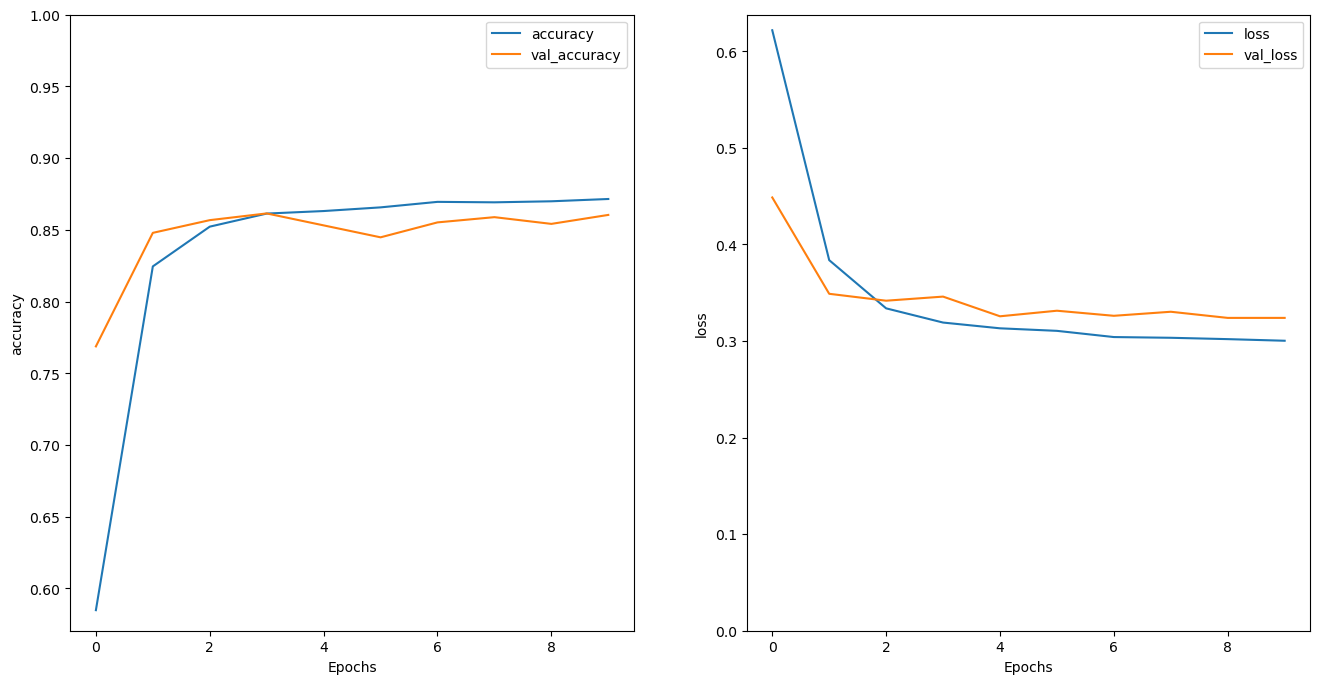

In [18]:
# membuat sebuah gambar (figure) dengan ukuran 16x8 inci untuk menampilkan kedua grafik secara bersamaan.
plt.figure(figsize=(16, 8))
# gambar dibagi menjadi dua sub-plot, dan ini adalah sub-plot pertama yang digunakan untuk menampilkan grafik akurasi.
plt.subplot(1, 2, 1)
# pemanggilan fungsi plot_graphs yang digunakan untuk membuat grafik akurasi berdasarkan data sejarah pelatihan (history) dan metrik akurasi.
plot_graphs(history, 'accuracy')
# mengatur batas sumbu y pada sub-plot pertama agar akurasi tampil dalam rentang antara 0 hingga 1.
plt.ylim(None, 1)
# sub-plot kedua digunakan untuk menampilkan grafik loss.
plt.subplot(1, 2, 2)
# pemanggilan fungsi plot_graphs yang digunakan untuk membuat grafik loss berdasarkan data sejarah pelatihan (history) dan metrik loss.
plot_graphs(history, 'loss')
# mengatur batas sumbu y pada sub-plot kedua agar loss tampil dalam rentang lebih dari 0.
plt.ylim(0, None)

In [19]:
# menggunakan model untuk melakukan prediksi sentimen pada contoh teks yang diberikan. 
sample_text = ('The movie was cool. The animation and the graphics ''were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))

1/1 [==============================] - 11s 11s/step


In [20]:
model = tf.keras.Sequential([
  encoder,
  # lapisan embedding yang mengubah vektor numerik yang dihasilkan oleh encoder menjadi representasi embedding dengan dimensi 64. 
  # mask_zero=True mengindikasikan bahwa lapisan ini akan menangani token nol dalam urutan data.
  tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
  # lapisan LSTM dengan 64 unit yang dilapis ganda (bidirectional). 
  # Lapisan ini mengembalikan urutan output (sequences) dari LSTM, yang akan menjadi masukan untuk lapisan berikutnya.
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
  # lapisan LSTM dengan 32 unit yang juga dilapis ganda (bidirectional). 
  # Ini adalah lapisan LSTM kedua yang mengambil output dari lapisan sebelumnya dan memberikan keluaran akhir.
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  # lapisan fully connected dengan 64 unit dan fungsi aktivasi ReLU.
  tf.keras.layers.Dense(64, activation='relu'),
  # lapisan dropout yang digunakan untuk mencegah overfitting dengan mengabaikan beberapa unit selama pelatihan.
  tf.keras.layers.Dropout(0.5),
  # lapisan fully connected terakhir dengan satu unit yang digunakan untuk melakukan klasifikasi biner (misalnya, sentimen positif atau negatif).
  tf.keras.layers.Dense(1)
])

In [21]:
# mengkonfigurasi kompilasi model dengan parameter-parameter yang sesuai untuk pelatihan model klasifikasi sentimen
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [22]:
# menggunakan model yang telah dikompilasi untuk melatih model dengan dataset pelatihan (train_dataset) selama 10 epoch, 
# sambil juga melakukan validasi dengan dataset pengujian (test_dataset).
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 25444s 65s/step - loss: 0.6243 - accuracy: 0.5864 - val_loss: 0.4283 - val_accuracy: 0.8057
Epoch 2/10
391/391 [==============================] - 4324s 11s/step - loss: 0.3872 - accuracy: 0.8314 - val_loss: 0.3429 - val_accuracy: 0.8495
Epoch 3/10
391/391 [==============================] - 4187s 11s/step - loss: 0.3351 - accuracy: 0.8568 - val_loss: 0.3351 - val_accuracy: 0.8589
Epoch 4/10
391/391 [==============================] - 4252s 11s/step - loss: 0.3188 - accuracy: 0.8648 - val_loss: 0.3343 - val_accuracy: 0.8359
Epoch 5/10
391/391 [==============================] - 4630s 12s/step - loss: 0.3102 - accuracy: 0.8676 - val_loss: 0.3148 - val_accuracy: 0.8542
Epoch 6/10
391/391 [==============================] - 4739s 12s/step - loss: 0.3083 - accuracy: 0.8707 - val_loss: 0.3209 - val_accuracy: 0.8573
Epoch 7/10
391/391 [==============================] - 4644s 12s/step - loss: 0.3058 - accuracy: 0.8690 - val_loss: 0.3183 - val_a

In [23]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 850s 2s/step - loss: 0.3137 - accuracy: 0.8575
Test Loss: 0.3137117326259613
Test Accuracy: 0.8575199842453003


In [24]:
# predict on a sample text without padding.

sample_text = ('The movie was not good. The animation and the graphics ' 'were terrible. I would not recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions)

1/1 [==============================] - 36s 36s/step
[[-1.79737]]


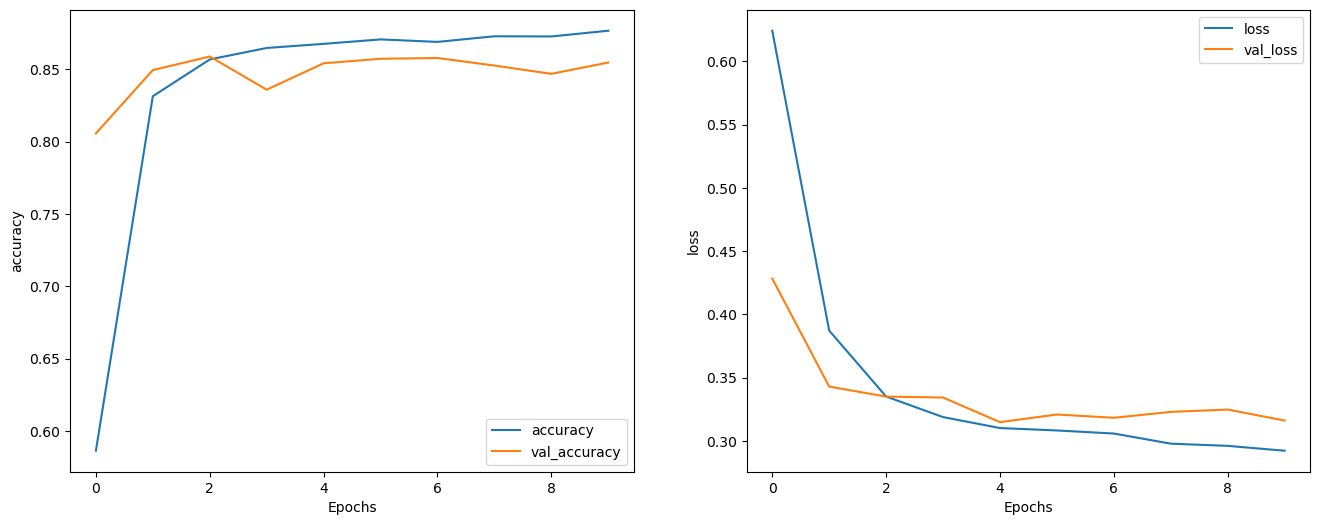

In [25]:
# membuat dua grafik yang menunjukkan perkembangan akurasi dan loss selama pelatihan model. 
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')